In [23]:
import os
import math
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

import tensorflow as tf

### Paths, defs

In [12]:
main_folder_path = '/datasets/amelatur/mimic_m1pz92hj/'
ids_file = pd.read_csv( main_folder_path + '0labels.txt')
patient_ids = ids_file['id']

vitals_folder_path = '/datasets/amelatur/mimic_kih7jlb3/'


In [13]:
# RESPI FAILURE

sampling_rate_minutes = 30
steps_per_hour = 60//sampling_rate_minutes

ffill_p_f_hours = 2 * steps_per_hour
pao2_normal = 80.0
fio2_normal = 21.0

p_f_ratio_threshold = 300
window_ratio = 2/3
window_length = 2 * steps_per_hour

peep_interpolate_limit = 4 * steps_per_hour

# EXTRA STUFF
paco2_normal = 40
paco2_threshold = 45
ph_normal = 7.4
ph_threshold = 7.35



In [14]:
# CIRC FAILURE
sampling_rate_minutes = 30
steps_per_hour = 60//sampling_rate_minutes

ffill_lactate_hours = 7 * steps_per_hour
ffill_drugs_hours = 1 * steps_per_hour
ffill_map_hours = 5 * steps_per_hour

lactate_normal_value = 1.0
map_normal_value = 90.0

lactate_threshold = 2
map_threshold = 65
window_ratio = 2/3
window_length = 2 * steps_per_hour

# EXTRA STUFF
hr_normal_value = 80
hr_threshold = 100

In [15]:
# pick a random subset of patients 
number_patients = 200
random_patient_ids = patient_ids.sample(n=number_patients, random_state=54)


# select which diseases
train_sepsis = False
train_respi = True
train_circ = False
train_kidney = False

### RESPIRATORY FAILURE

In [26]:
def get_respi_fail (patient_id):

    labs_file = pd.read_csv(main_folder_path + str(patient_id) + '_all_vals.csv', index_col=False)
    labs_file['charttime'] = pd.to_datetime(labs_file['charttime'])
    labs_file = labs_file.sort_values(by='charttime').set_index('charttime')

    index_ = labs_file.index
    n_steps = len(labs_file.index)

    # annotate respiratory failure
    respi_status = pd.Series(0, index=index_)

    # P/F ratio
    if not (labs_file['po2'].isna().all() or n_steps < 48):
        exclusion_flag = 0
        p_f_raw = labs_file[['po2', 'fio2']].reindex(index_, method='ffill', limit=ffill_p_f_hours) 
        p_f_raw = p_f_raw.interpolate(limit=ffill_p_f_hours)
        p_f_raw['po2'] = p_f_raw['po2'].fillna(80.0) 
        p_f_raw['fio2'] = p_f_raw['fio2'].fillna(21.0)
        ratio = 100 * p_f_raw['po2'] / p_f_raw['fio2'] 

        p_f_ratio =  pd.Series(ratio, index=index_)


        # get ventilation status
        vent_df = labs_file['vent_presence']

        # peep 
        peep_interpolate_limit = 4 * steps_per_hour
        peep = labs_file['peep'].reindex(index_, method='ffill', limit=peep_interpolate_limit).squeeze()

        # take element-wise AND of peep and ventilation
        vent_peep_status_dense = vent_df.squeeze() & peep.squeeze() > 4

        peep[peep.isnull()] = 1
        peep[~peep.isnull()] = 0
        vent_peep_status_not_dense = (vent_df.squeeze()) & peep
        
        # annotate respiratory failure
        respi_status = pd.DataFrame(0, index=index_, columns=['respi_failure']).squeeze()

        n_steps = len(vent_peep_status_not_dense)

        for i in range(n_steps):
            start_window = i
            end_window = min(n_steps, i + 2 * steps_per_hour)

            vent_win = np.array(vent_peep_status_dense[start_window:end_window])
            vent_win_not_dense = np.array(vent_peep_status_not_dense[start_window:end_window])
            p_f_win = np.array(p_f_ratio[start_window:end_window])
            
            no_vent_cond = np.sum((p_f_win < 300) & (vent_win == False)) >= 1/2 * len(vent_win)
            vent_cond_not_dense = np.sum((p_f_win < 300)& (vent_win_not_dense)) >= 1/2 * len(vent_win)
            vent_cond_dense = np.sum((p_f_win) < 300 & (vent_win)) >= 1/2 * len(vent_win)

            #vent_cond = np.sum((vent_win)) >= 2/3 * len(vent_win)

            final = no_vent_cond + vent_cond_not_dense + vent_cond_dense
            if final: 
                respi_status.iloc[i] = 1
    else:
        exclusion_flag = 1

    # now return time of event
    threshold = 3
    result_index = respi_status[respi_status.groupby((respi_status != respi_status.shift()).cumsum()[respi_status.eq(1)]).transform('count') > threshold]
    if result_index.empty == False:
        result_index = respi_status.index.get_loc(result_index.idxmax())
    else:
        result_index = None

    # now return an array that is full of 1s 6H before the event, and 2H after the event, and 0s otherwise (clip the array 2H after event)
    final_target_series = pd.Series(0, index=index_)
    if result_index != None:
        start_event = max(0, result_index - 6*2)
        end_event = min(n_steps, result_index + 2*2)
        final_target_series.iloc[start_event:end_event] = 1


    # now get the vitals as inputs
    vitals_file = pd.read_csv(vitals_folder_path + str(patient_id) + '_vitals.csv', index_col=False)
    vitals_file['time'] = pd.to_datetime(vitals_file['time'])
    vitals_file = vitals_file.set_index('time')
    vitals = vitals_file.drop(['Unnamed: 0', 'id'], axis=1).resample('30T').mean() 
    vitals = vitals.ffill().bfill()
    if vitals.isna().any().any():
        exclusion_flag = 1


    # now calculate the number of valid tensors that we can use
    
    nb_timesteps_per_tensor = 4*2 # 2 steps per hour, 4H total --> 8 timesteps per tensor
    if result_index != None:
        end_index_usable = math.ceil(end_event / nb_timesteps_per_tensor) * nb_timesteps_per_tensor
        vitals = vitals[:end_index_usable]
        final_target_series.iloc[end_event:end_index_usable] = 1
        final_target_series = final_target_series[:end_index_usable]

    

    input_dataset = tf.keras.utils.timeseries_dataset_from_array(np.array(vitals), None, sequence_length = 4*2)
    target_dataset = tf.keras.utils.timeseries_dataset_from_array(np.array(final_target_series), None, sequence_length = 4*2)

    return exclusion_flag, input_dataset, target_dataset

In [29]:
exclusion_flag, input_dataset, target_dataset = get_respi_fail(random_patient_ids.iloc[0])
# for batch in input_dataset:
#   inputs = batch
#   print (inputs.shape)
# print("______")
# for batch in target_dataset:
#   target = batch
#   print ((target))

### CIRCULATORY FAILURE

In [30]:
def get_circ_fail(patient_id):

    #vitals_file = pd.read_csv(main_folder_path + str(patient_id) + '_vitals.csv', index_col=False)
    labs_file = pd.read_csv(main_folder_path + str(patient_id) + '_all_vals.csv', index_col=False)

    #vitals_file['time'] = pd.to_datetime(vitals_file['time'])
    labs_file['charttime'] = pd.to_datetime(labs_file['charttime'])

    #vitals_file = vitals_file.set_index('time')
    labs_file = labs_file.set_index('charttime')
    index_ = labs_file.index
    n_steps = len(labs_file.index)
    circ_status = pd.Series(0, index=index_, name="circ")

    # if not (labs_file['mbp'].isna().all() or labs_file['uo_rt_6hr'].isna().all() or labs_file['heart_rate'].isna().all() or labs_file['lactate'].isna().all() or n_steps < 48):
    if not (n_steps < 48 or labs_file['mbp'].isna().all() or labs_file['lactate'].isna().all()):
        excl_flag = 0
        lactate_final = labs_file['lactate']
        lactate_final = lactate_final.ffill(limit=ffill_lactate_hours)
        lactate_final.loc[:lactate_final.first_valid_index()] = lactate_normal_value
        lactate_final = lactate_final.interpolate(limit=ffill_lactate_hours)
        lactate_final = lactate_final.fillna(lactate_normal_value)

        drug_df = labs_file['drug_presence'] # to series

        map_values = labs_file['mbp']
        map_values = map_values.ffill(limit=ffill_map_hours)
        map_values.loc[:map_values.first_valid_index()] = map_normal_value
        map_values = map_values.interpolate(limit=ffill_map_hours)
        map_values = map_values.fillna(map_normal_value)

        # Now calculate circ failure on imputed dataframes
        # final circ_status column filled with 0s
        event_window_length = window_length
        half_length = event_window_length//2

        # EXTRA STUFF: HR --> impute in the same manner as all values above (MAP, lactate)
        hr = labs_file['heart_rate']
        hr = hr.ffill(limit=ffill_map_hours)
        hr.loc[:hr.first_valid_index()] = hr_normal_value
        hr = hr.interpolate(limit=ffill_map_hours)
        hr = hr.fillna(hr_normal_value)

        # urine output
        uo = labs_file['uo_rt_6hr']
        uo = uo.ffill()
        uo = uo.fillna(1.5)

        for idx in range(n_steps):

            start_idx = max(0, idx - half_length)
            end_idx = min(n_steps, idx + half_length)

            map_wind = np.array(map_values[start_idx:end_idx+1])
            lactate_wind = np.array(lactate_final[start_idx:end_idx+1])
            drugs_wind = np.array(drug_df[start_idx:end_idx+1])
            hr_wind = np.array(hr[start_idx:end_idx+1])
            uo_wind = np.array(uo[start_idx:end_idx+1])

            pharma_cond = drugs_wind > 0
            map_cond = map_wind < 70
            hr_cond = hr_wind > hr_threshold
            uo_cond = uo_wind < 0.5

            map_full_cond = (map_cond | pharma_cond)
            #map_full_cond = map_cond
            lact_crit_arr = (lactate_wind > 1.5)
            map_state = np.sum(map_full_cond) >= window_ratio * len(map_full_cond)
            lac_state = np.sum(lact_crit_arr) >= window_ratio * len(map_full_cond)
            uo_state = np.sum(uo_cond) >= window_ratio * len(map_full_cond)
            hr_state = np.sum(hr_cond) >= 1/2 * len(map_full_cond)
            secondary = lac_state or uo_state
            if map_state and lac_state:
            # if (map_state and lac_state):
                circ_status.iloc[idx] = 1.0

    else:
        excl_flag = 1

    # now return time of event
    threshold = 3
    result_index = circ_status[circ_status.groupby((circ_status != circ_status.shift()).cumsum()[circ_status.eq(1)]).transform('count') > threshold]
    if result_index.empty == False:
        result_index = circ_status.index.get_loc(result_index.idxmax())
    else:
        result_index = None
    
    return circ_status, excl_flag, result_index

### ACUTE KIDNEY INJURY

In [31]:
def get_kidney_fail(patient_id):
    #vitals_file = pd.read_csv(main_folder_path + str(patient_id) + '_vitals.csv', index_col=False)
    labs_file = pd.read_csv(main_folder_path + str(patient_id) + '_all_vals.csv', index_col=False)

    #vitals_file['time'] = pd.to_datetime(vitals_file['time'])
    labs_file['charttime'] = pd.to_datetime(labs_file['charttime'])

    #vitals_file = vitals_file.set_index('time')
    labs_file = labs_file.set_index('charttime')
    n_steps = len(labs_file.index)
    if (n_steps < 48):
        excl_flag = 1
    else:
        excl_flag = 0

    kidney_status = pd.Series(0, index=labs_file.index, name="kidney")
    target_value = 2.0
    earliest_index = labs_file['aki_stage'].squeeze().eq(target_value)
    if earliest_index.any() == True:
        earliest_index = labs_file.index.get_loc(earliest_index.idxmax())
        kidney_status[earliest_index:] = 1
    else:
        earliest_index = None

    return labs_file['aki_stage'], excl_flag, earliest_index, kidney_status




In [32]:
aki, excl_flag, earliest_index, kidney_status = get_kidney_fail(random_patient_ids.iloc[150])
print(aki[10:30], kidney_status[10:30])

charttime
2180-09-20 16:00:00    0.0
2180-09-20 16:30:00    NaN
2180-09-20 17:00:00    NaN
2180-09-20 17:30:00    NaN
2180-09-20 18:00:00    0.0
2180-09-20 18:30:00    NaN
2180-09-20 19:00:00    0.0
2180-09-20 19:30:00    0.0
2180-09-20 20:00:00    0.0
2180-09-20 20:30:00    NaN
2180-09-20 21:00:00    0.0
2180-09-20 21:30:00    NaN
2180-09-20 22:00:00    NaN
2180-09-20 22:30:00    NaN
2180-09-20 23:00:00    NaN
2180-09-20 23:30:00    NaN
2180-09-21 00:00:00    2.0
2180-09-21 00:30:00    NaN
2180-09-21 01:00:00    1.0
2180-09-21 01:30:00    NaN
Name: aki_stage, dtype: float64 charttime
2180-09-20 16:00:00    0
2180-09-20 16:30:00    0
2180-09-20 17:00:00    0
2180-09-20 17:30:00    0
2180-09-20 18:00:00    0
2180-09-20 18:30:00    0
2180-09-20 19:00:00    0
2180-09-20 19:30:00    0
2180-09-20 20:00:00    0
2180-09-20 20:30:00    0
2180-09-20 21:00:00    0
2180-09-20 21:30:00    0
2180-09-20 22:00:00    0
2180-09-20 22:30:00    0
2180-09-20 23:00:00    0
2180-09-20 23:30:00    0
2180-09-

### SEPSIS

In [21]:
def get_sepsis(patient_id):

    detected_sepsis = ids_file[ids_file['id'] == patient_id]['sepsis'].values[0]
    
    labs_file = pd.read_csv(main_folder_path + str(patient_id) + '_all_vals.csv', index_col=False)
    labs_file['charttime'] = pd.to_datetime(labs_file['charttime'])
    labs_file = labs_file.set_index('charttime')
    n_steps = len(labs_file.index)
    excl_flag = 0
    sepsis_index = None
    sepsis_time = None
    if (n_steps < 48):
        excl_flag = 1
    if detected_sepsis == True:
        sepsis_time = pd.to_datetime(ids_file[ids_file['id'] == patient_id]['sepsis_time'].values[0])
        first_vital = min(labs_file.index)
        if (sepsis_time < first_vital):
            excl_flag = 1
        sepsis_index = labs_file.index.get_loc(sepsis_time) 
    
    return detected_sepsis, excl_flag, sepsis_index


### TF Dataloaders

In [13]:
import tensorflow as tf

def data_generator():
    # Your data generation logic goes here
        exclusion_flag, input_dataset, target_dataset = get_respi_fail(pat_id)
        if exclusion_flag == 0:
            return input_dataset, target_dataset


def custom_data_loader(batch_size):
    # Create a dataset from the generator function
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        output_types=(tf.float32, tf.float32)
    )

    # Batch and prefetch the dataset
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

# Specify the batch size
batch_size = 32

# Create the custom data loader
data_loader = custom_data_loader(batch_size)

# Example of using the data loader in a training loop
for inputs, targets in data_loader:
    # Your training logic goes here
    print("Inputs shape:", inputs.shape)
    print("Targets shape:", targets.shape)

2024-01-17 15:20:58.439646: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32), but the yielded element was <_BatchDataset element_spec=TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None)>.
Traceback (most recent call last):

  File "/home/amelatur/.pyenv/versions/3.10.12/envs/my_proj/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 204, in generator_py_func
    flattened_values = nest.flatten_up_to(output_types, values)

  File "/home/amelatur/.pyenv/versions/3.10.12/envs/my_proj/lib/python3.10/site-packages/tensorflow/python/data/util/nest.py", line 237, in flatten_up_to
    return nest_util.flatten_up_to(

  File "/home/amelatur/.pyenv/versions/3.10.12/envs/my_proj/lib/python3.10/site-packages/tensorflow/python/util/nest_util.py", line 1542, in flatten_up_to
    return _tf_data_flatten_up_

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32), but the yielded element was <_BatchDataset element_spec=TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None)>.
Traceback (most recent call last):

  File "/home/amelatur/.pyenv/versions/3.10.12/envs/my_proj/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 204, in generator_py_func
    flattened_values = nest.flatten_up_to(output_types, values)

  File "/home/amelatur/.pyenv/versions/3.10.12/envs/my_proj/lib/python3.10/site-packages/tensorflow/python/data/util/nest.py", line 237, in flatten_up_to
    return nest_util.flatten_up_to(

  File "/home/amelatur/.pyenv/versions/3.10.12/envs/my_proj/lib/python3.10/site-packages/tensorflow/python/util/nest_util.py", line 1542, in flatten_up_to
    return _tf_data_flatten_up_to(shallow_tree, input_tree)

  File "/home/amelatur/.pyenv/versions/3.10.12/envs/my_proj/lib/python3.10/site-packages/tensorflow/python/util/nest_util.py", line 1571, in _tf_data_flatten_up_to
    _tf_data_assert_shallow_structure(shallow_tree, input_tree)

  File "/home/amelatur/.pyenv/versions/3.10.12/envs/my_proj/lib/python3.10/site-packages/tensorflow/python/util/nest_util.py", line 1415, in _tf_data_assert_shallow_structure
    raise TypeError(

TypeError: If shallow structure is a sequence, input must also be a sequence. Input has type: '_BatchDataset'.


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/home/amelatur/.pyenv/versions/3.10.12/envs/my_proj/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/home/amelatur/.pyenv/versions/3.10.12/envs/my_proj/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/home/amelatur/.pyenv/versions/3.10.12/envs/my_proj/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 206, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32), but the yielded element was <_BatchDataset element_spec=TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None)>.


	 [[{{node PyFunc}}]] [Op:IteratorGetNext] name: 

In [13]:
list_inputs = []
list_targets = []

for idx, pat_id in random_patient_ids.items():
    exclusion_flag, input_dataset, target_dataset = get_respi_fail(pat_id)
    if exclusion_flag == 0:
        for batch in input_dataset:
            list_inputs.append(batch)
        for batch in target_dataset:
            list_targets.append(batch)



2024-01-18 09:45:28.111189: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-18 09:45:28.562735: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-18 09:45:28.562991: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [40]:
exclusion_flag, input_dataset, target_dataset = get_respi_fail(random_patient_ids.iloc[150])

for batch in input_dataset:
    for tensor in batch:
        print(type(np.array(tensor)))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [14]:
final_input_dataset = tf.concat(list_inputs, 0)
final_target_dataset = tf.concat(list_targets, 0)

### TF Time Series Models

In [2]:
import tensorflow as tf
from tensorflow. layers import Input, Conv1D, GlobalAveragePooling1D, Dense, Attention


# CONV1D WITH ATTENTION
def create_conv1d_attention_model(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = Conv1D(128, kernel_size=3, activation='relu')(x)
    attention = Attention()([x, x])
    x = GlobalAveragePooling1D()(attention)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(input_shape[0], activation='sigmoid')(x)  # Sigmoid for binary classification

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model


# CONV1D WITHOUT ATTENTION
def create_conv1d(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = Conv1D(128, kernel_size=3, activation='relu')(x)
    attention = Attention()([x, x])
    x = GlobalAveragePooling1D()(attention)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(input_shape[0], activation='sigmoid')(x)  # Sigmoid for binary classification

    model = tf. Model(inputs=inputs, outputs=outputs)

    return model

input_shape = (8, 7)

model = create_conv1d(input_shape)
model.summary()

model.compile(optimizer='adam',
              loss=tf. losses.BinaryCrossentropy(),
              metrics=['accuracy'])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8, 7)]               0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 6, 64)                1408      ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 4, 128)               24704     ['conv1d[0][0]']              
                                                                                                  
 attention (Attention)       (None, 4, 128)               0         ['conv1d_1[0][0]',            
                                                                     'conv1d_1[0][0]']        

2024-01-24 15:50:10.755203: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-24 15:50:10.943506: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-24 15:50:10.943644: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, Attention, BatchNormalization, ReLU
from tensorflow.keras.models import Model

sampling_rate_mins = 5
n_timesteps = 60//sampling_rate_mins
window_length_hours = 4

nb_features_vitals = 6 

def create_conv1d(input_shape):
    
    input_layer =  Input(input_shape)

    conv1 = Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)

    conv2 = Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)

    conv3 = Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)

    gap = GlobalAveragePooling1D()(conv3)

    output_layer = Dense(input_shape[0], activation="sigmoid")(gap)

    return Model(inputs=input_layer, outputs=output_layer)

input_shape = (window_length_hours * n_timesteps, nb_features_vitals)

model = create_conv1d(input_shape)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 48, 6)]           0         
                                                                 
 conv1d_11 (Conv1D)          (None, 48, 64)            1216      
                                                                 
 batch_normalization_9 (Bat  (None, 48, 64)            256       
 chNormalization)                                                
                                                                 
 re_lu_9 (ReLU)              (None, 48, 64)            0         
                                                                 
 conv1d_12 (Conv1D)          (None, 48, 64)            12352     
                                                                 
 batch_normalization_10 (Ba  (None, 48, 64)            256       
 tchNormalization)                                         

In [16]:
model.fit(final_input_dataset, final_target_dataset, epochs=100, batch_size=32, validation_split=0.15)

Epoch 1/100


2024-01-18 09:46:27.084051: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-18 09:46:27.323676: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-18 09:46:28.033563: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-18 09:46:28.793829: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd437bbd780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-18 09:46:28.793849: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-01-18 09:46:28.828001: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705567588.950806 1254904 device_compil

149/149 [==============================] - 8s 27ms/step - loss: 0.5058 - accuracy: 0.1435 - val_loss: 0.6237 - val_accuracy: 0.1493
Epoch 2/100
149/149 [==============================] - 1s 9ms/step - loss: 0.3005 - accuracy: 0.1300 - val_loss: 0.6155 - val_accuracy: 0.0048
Epoch 3/100
149/149 [==============================] - 1s 9ms/step - loss: 0.2892 - accuracy: 0.0960 - val_loss: 0.5816 - val_accuracy: 0.4074
Epoch 4/100
149/149 [==============================] - 1s 9ms/step - loss: 0.2842 - accuracy: 0.1078 - val_loss: 0.5804 - val_accuracy: 0.0072
Epoch 5/100
149/149 [==============================] - 1s 10ms/step - loss: 0.2816 - accuracy: 0.0928 - val_loss: 0.5959 - val_accuracy: 0.2115
Epoch 6/100
149/149 [==============================] - 1s 10ms/step - loss: 0.2757 - accuracy: 0.1002 - val_loss: 0.6258 - val_accuracy: 0.0131
Epoch 7/100
149/149 [==============================] - 1s 9ms/step - loss: 0.2801 - accuracy: 0.0916 - val_loss: 0.5563 - val_accuracy: 0.0346
Epoch 8/

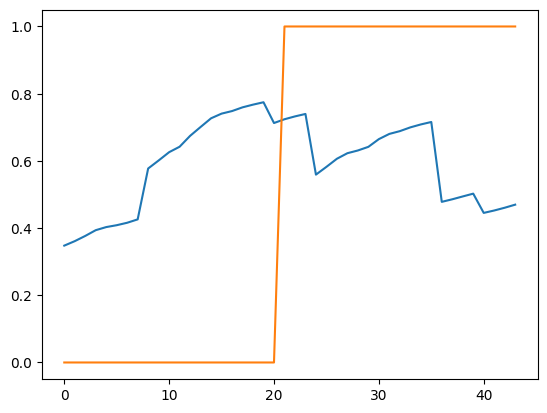

In [33]:
# look at some results
import numpy as np
import matplotlib.pyplot as plt
path = ('/datasets/amelatur/data_slices/respiratory/baseline/30111809_final_predictions.npy')
arr = np.load(path)
plt.plot(arr[0])
plt.plot(arr[1])
plt.show()

In [34]:
predictions = arr[0]

(predictions > 0.5).astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0])

In [38]:
target = (np.zeros((predictions.shape))).astype(int)
onset = 20
start_event = max(0, onset - 8 * 2)
target[start_event:onset]  =1
target

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [39]:
import pandas as pd
file = pd.read_csv('/datasets/amelatur/data_slices/respiratory/onset_index.csv', header=None, index_col=False)



In [45]:
np.isnan(file[1][1])

True

In [41]:
filename = "30111809_final_predictions.npy"
str = filename.split("_")
pt_id = str[0]

In [42]:
str

['30111809', 'final', 'predictions.npy']

In [32]:
int(file[file[0] == 34995687][1].values[0])

35